In [1]:
import napari
import napari_convpaint
import numpy as np
import matplotlib.pyplot as plt
import skimage
from napari_convpaint import conv_paint_model, conv_paint_feature_extractor, conv_paint_param
import torch
import pickle
from napari_convpaint.conv_paint_model import ConvpaintModel
from dask.distributed import Client, LocalCluster, get_client
from skimage.util import view_as_windows

In [9]:
def process_tile(tile):
    return model.segment(tile)


def split_into_tiles(image, tile_size=512, margin=32):
    """
    Teilt ein Bild in überlappende Tiles mit Randbereich (margin)
    """
    # Padding hinzufügen für gleichmäßige Tile-Verteilung
    pad_h = (tile_size - (image.shape[0] % tile_size)) % tile_size
    pad_w = (tile_size - (image.shape[1] % tile_size)) % tile_size
    
    # Spiegeln der Ränder für nahtlose Übergänge
    padded_image = np.pad(
        image,
        ((margin, pad_h + margin), 
         (margin, pad_w + margin), 
         (0, 0)),
        mode='reflect'
    )
    
    # Tiles mit Überlappung erstellen
    window_shape = (
        tile_size + 2*margin,  # Höhe mit Margin
        tile_size + 2*margin,  # Breite mit Margin
        image.shape[2]         # Kanäle
    )
    
    step = tile_size  # Schrittweite ohne Überlappung
    tiles = view_as_windows(padded_image, window_shape, step=step)
    
    # Umformen zu (n_tiles, tile_height, tile_width, channels)
    return tiles.reshape(-1, *window_shape)


def combine_tiles(tiles, original_shape, tile_size=512, margin=32):
    """
    Kombiniert verarbeitete Tiles zurück zum Originalbild
    """
    # Berechne benötigte Dimensionen
    n_tiles_h = int(np.ceil(original_shape[0] / tile_size))
    n_tiles_w = int(np.ceil(original_shape[1] / tile_size))
    
    # Leeres Bild vorbereiten
    reconstructed = np.zeros((
        n_tiles_h * tile_size,
        n_tiles_w * tile_size,
        original_shape[2]
    ), dtype=tiles[0].dtype)
    
    # Tiles einsetzen (mit Margin-Cropping)
    tile_idx = 0
    for i in range(n_tiles_h):
        for j in range(n_tiles_w):
            # Aktuelle Tile-Position
            y_start = i * tile_size
            x_start = j * tile_size
            
            # Margin entfernen
            tile = tiles[tile_idx][
                margin:-margin,
                margin:-margin,
                :
            ]
            
            # Tile einsetzen
            reconstructed[
                y_start:y_start+tile_size,
                x_start:x_start+tile_size,
                :
            ] = tile
            
            tile_idx += 1
    
    # Originalgröße zurechtschneiden
    return reconstructed[:original_shape[0], :original_shape[1], :]

In [4]:
annotations = skimage.io.imread('Data/annotations.tif')
image = skimage.io.imread('Data/microscope/aegypti/ag_03.tif')

In [ ]:
model = ConvpaintModel(model_path="Models/Enet_v6.pkl")
model.set_params(
    image_downsample=2
    )

# 1. Tiles erstellen
tiles = split_into_tiles(image, tile_size=512, margin=32)

In [22]:
# 2. Verarbeitung mit Dask
from dask.distributed import Client
client = Client(n_workers=4, memory_limit='16GB')

futures = []
for tile in tiles:
    future = client.submit(model.segment, tile)
    futures.append(future)

# Ergebnisse sammeln
# processed_tiles = client.gather(futures)

/home/tibor/tf/tf-gpu/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39659 instead
  warnings.warn(


In [23]:
processed_tiles = client.gather(futures)

In [ ]:
# 3. Tiles kombinieren
segmentation = combine_tiles(
    processed_tiles,
    original_shape=image.shape,
    tile_size=512,
    margin=32
)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

Info: Cellpose is not installed and is not available as feature extractor.
Run 'pip install napari-convpaint[cellpose]' to install it.
Info: Ilastik is not installed and is not available as feature extractor.
Run 'pip install napari-convpaint[ilastik]' to install it.
Make sure to also have fastfilters installed ('conda install -c ilastik-forge fastfilters').


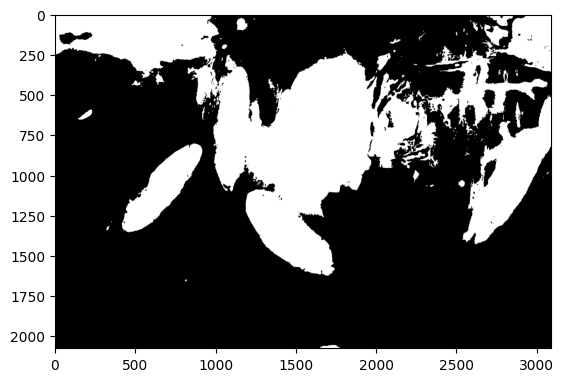

In [2]:
from napari_convpaint.conv_paint_model import ConvpaintModel
import skimage
import matplotlib.pyplot as plt
import numpy as np

image = skimage.io.imread('Data/phone/aegypti/IMG_20250521_110710_682.jpg')
# image = skimage.io.imread('Data/microscope/aegypti/ag_07.tif')

image = skimage.transform.resize(image, (2076, 3088, 3), preserve_range=True)
image = np.moveaxis(image, -1, 0)
# image.transpose(2, 0, 1)

geladenes_modell = ConvpaintModel(model_path="Models/Enet_v7.pkl")
# geladenes_modell.set_params(image_downsample=2, seg_smoothening=1)


segment = geladenes_modell.segment(image)
plt.imshow(segment, cmap='gray')

In [42]:
image = skimage.io.imread('Data/phone/aegypti/IMG_20250521_110710_682.jpg')
image

array([[[ 66,  80,  89],
        [ 66,  80,  89],
        [ 66,  80,  89],
        ...,
        [ 60,  51,  42],
        [ 60,  51,  42],
        [ 60,  51,  42]],

       [[ 65,  79,  88],
        [ 66,  80,  89],
        [ 66,  80,  89],
        ...,
        [ 61,  52,  43],
        [ 61,  52,  43],
        [ 61,  52,  43]],

       [[ 65,  79,  88],
        [ 65,  79,  88],
        [ 66,  80,  89],
        ...,
        [ 62,  53,  44],
        [ 62,  53,  44],
        [ 61,  52,  43]],

       ...,

       [[200, 180, 156],
        [201, 181, 157],
        [201, 181, 157],
        ...,
        [123,  92,  97],
        [123,  92,  97],
        [123,  92,  97]],

       [[200, 180, 156],
        [201, 181, 157],
        [201, 181, 157],
        ...,
        [123,  92,  97],
        [123,  92,  97],
        [123,  92,  97]],

       [[200, 180, 156],
        [201, 181, 157],
        [201, 181, 157],
        ...,
        [123,  92,  97],
        [123,  92,  97],
        [123,  92,  97]]

In [43]:
image = skimage.transform.resize(image, (2076, 3088))
image

array([[[0.2586699 , 0.31357186, 0.34886598],
        [0.25882353, 0.31372549, 0.34901961],
        [0.25882353, 0.31372549, 0.34901961],
        ...,
        [0.23833392, 0.20303981, 0.16774569],
        [0.23547546, 0.20018134, 0.16488723],
        [0.23547546, 0.20018134, 0.16488723]],

       [[0.25541822, 0.31032018, 0.34561429],
        [0.25852896, 0.31343092, 0.34872504],
        [0.25882353, 0.31372549, 0.34901961],
        ...,
        [0.23934394, 0.20404983, 0.16875571],
        [0.23975972, 0.2044656 , 0.16917148],
        [0.23929884, 0.20400472, 0.16871061]],

       [[0.25490196, 0.30980392, 0.34509804],
        [0.25670019, 0.31160215, 0.34689627],
        [0.25882353, 0.31372549, 0.34901961],
        ...,
        [0.24083316, 0.20553904, 0.17024493],
        [0.24313725, 0.20784314, 0.17254902],
        [0.24058323, 0.20528911, 0.16999499]],

       ...,

       [[0.78491314, 0.70648176, 0.61236412],
        [0.78823529, 0.70980392, 0.61568627],
        [0.78823529, 0

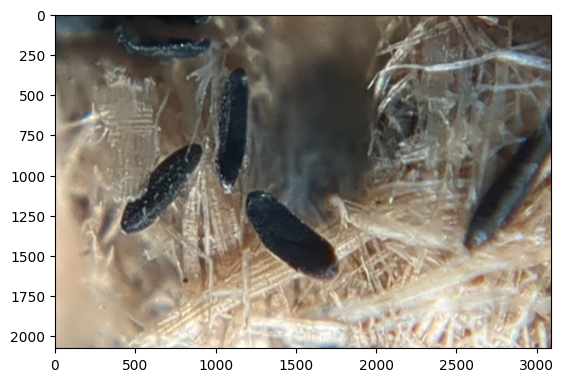

In [21]:
plt.imshow(image)

In [27]:
np.any(segment != 1)

np.False_

In [35]:
image = np.moveaxis(image, -2, 0)  # (C, H, W)

In [35]:
segment.shape

(2076, 3088)

In [26]:
image.shape

(3, 2076, 3088)

In [5]:
cluster = LocalCluster(
    n_workers=4,
    threads_per_worker=1,  # Reduzieren für weniger Overhead
    memory_limit='16GB',   # Gesamtspeicher für alle Worker
    processes=True         # Kritisch für Memory-Isolation
)
client = Client(cluster)
print(client.dashboard_link)

http://127.0.0.1:8787/status


In [ ]:
try:
    client = get_client()
except ValueError:
    client = Client(n_workers=4, memory_limit="16GB", processes=True)
    client.register_worker_plugin(...)
print(client.dashboard_link)

In [ ]:
tiles = split_into_tiles(image, tile_size=512)  # Implementierung benötigt

# Tasks explizit an Client senden
futures = client.map(process_tile, tiles)
results = client.gather(futures)
segmentation = combine_tiles(results)

# 4. Dashboard-Link erzwingen
print(f"Dashboard: {client.dashboard_link}")
client.get_task_stream()  # Erzwingt Aktivitätsaufzeichnung

# Code zum trainieren und speichern eines Models in Napari-convpaint

In [3]:
import numpy as np
import skimage
from napari_convpaint.conv_paint_model import ConvpaintModel

# 1. Modell mit korrigierten Parametern initialisieren
model = ConvpaintModel(
    fe_name="efficient_netb0",
    fe_use_cuda=True,
    fe_layers=[0],  # Explizit erste Conv-Schicht auswählen
    fe_scalings=[1]  # Keine zusätzliche Skalierung
)

# 2. Parameter für große Bilder setzen
model.set_params(
    image_downsample=1,
    tile_annotations=True,
    tile_image=True,  # Bild in Tiles aufteilen
    clf_iterations=100,
    seg_smoothening=3  # Glättung für große Bilder
)

# 3. Bild und Annotationen vorverarbeiten
# Annahme: Originalbild (2076, 3088, 3), Annotationsmaske (2076, 3088)
# image = skimage.transform.resize(image, (1038, 1544, 3), preserve_range=True, order=1)
# annotations = skimage.transform.resize(annotations.astype(float), (1038, 1544), order=0, preserve_range=True)

# 4. Sicherstellen, dass Annotationen gültig sind
annotations = annotations.astype(np.uint8)
assert np.any(annotations > 0), "Annotationen dürfen nicht leer sein!"

# 5. Modell trainieren
try:
    model.train(image.transpose(2, 0, 1), annotations)  # Shape [C, H, W]
except Exception as e:
    print(f"Fehler beim Training: {str(e)}")
    # Debugging: Feature-Shapes prüfen
    features, targets = model.get_features_current_layers(image.transpose(2, 0, 1), annotations)
    print(f"Features shape: {features.shape}, Targets shape: {targets.shape}")

# 6. Segmentierung durchführen
segmentation = model.segment(image.transpose(2, 0, 1))


0:	learn: 0.5278456	total: 63.5ms	remaining: 6.28s
1:	learn: 0.4023568	total: 72.9ms	remaining: 3.57s
2:	learn: 0.3099158	total: 79ms	remaining: 2.55s
3:	learn: 0.2562575	total: 87.3ms	remaining: 2.09s
4:	learn: 0.2148548	total: 94.9ms	remaining: 1.8s
5:	learn: 0.1786913	total: 101ms	remaining: 1.58s
6:	learn: 0.1525575	total: 111ms	remaining: 1.47s
7:	learn: 0.1385150	total: 118ms	remaining: 1.35s
8:	learn: 0.1283720	total: 124ms	remaining: 1.26s
9:	learn: 0.1185651	total: 131ms	remaining: 1.18s
10:	learn: 0.1101662	total: 141ms	remaining: 1.14s
11:	learn: 0.0993679	total: 146ms	remaining: 1.07s
12:	learn: 0.0943633	total: 153ms	remaining: 1.03s
13:	learn: 0.0887477	total: 160ms	remaining: 986ms
14:	learn: 0.0859961	total: 166ms	remaining: 940ms
15:	learn: 0.0817522	total: 171ms	remaining: 898ms
16:	learn: 0.0777773	total: 177ms	remaining: 866ms
17:	learn: 0.0755011	total: 182ms	remaining: 830ms
18:	learn: 0.0736844	total: 187ms	remaining: 799ms
19:	learn: 0.0714849	total: 194ms	remai

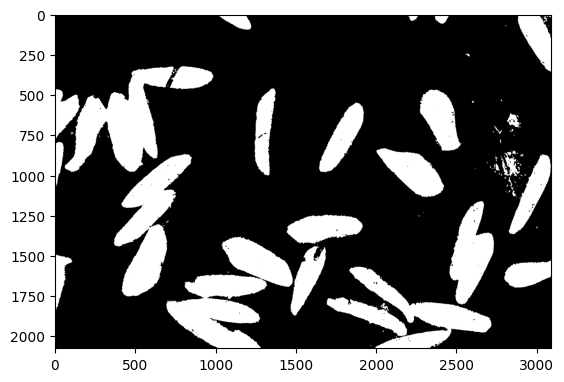

In [6]:
plt.imshow(segmentation, cmap='gray')

In [131]:
import napari
viewer = napari.Viewer()
viewer.add_image(image, name="Input")
viewer.add_labels(segmentation, name="Segmentierung")
napari.run()

Dropped Escape call with ulEscapeCode : 0x03007703


In [3]:
import numpy as np
from napari_convpaint.conv_paint_model import ConvpaintModel

# 1. Modell mit den exportierten Einstellungen initialisieren
model = ConvpaintModel(
    fe_name="efficient_netb0",
    fe_layers=[
        'features.0.0 Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)',
        'features.1.0.block.0.0 Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)'
    ],
    fe_scalings=[1, 2],
    fe_use_cuda=False  # In der GUI war CUDA deaktiviert
)

# 2. Alle exportierten Parameter setzen
model.set_params(
    clf_depth=5,
    clf_iterations=50,
    clf_learning_rate=0.1,
    fe_order=0,
    fe_use_min_features=False,
    image_downsample=1,
    multi_channel_img=False,
    normalize=3,  # Wichtig: Normalisierung pro Einzelbild
    rgb_img=True,  # Kritisch für RGB-Behandlung
    seg_smoothening=1,
    tile_annotations=True,
    tile_image=True
)

# 3. Bildvorbereitung für EfficientNetB0
# Annahme: Originalbild Shape (2076, 3088, 3)
# - Auf Wertebereich 0-255 normalisieren
# - Channel-Order umwandeln zu [H, W, C] -> [C, H, W]
image = image.transpose(2, 0, 1).astype(np.float32)
image /= 255.0  # Normalisierung auf [0,1]

# 4. Annotationen prüfen (müssen mit Bildgröße übereinstimmen)
assert annotations.shape == (2076, 3088), "Falsche Annotation Shape"
annotations = annotations.astype(np.uint8)

# 5. Training mit GUI-kompatiblen Einstellungen
try:
    model.train(image, annotations)
except Exception as e:
    print(f"Training fehlgeschlagen: {str(e)}")
    # Debug: Feature-Größen prüfen
    features, targets = model.get_features_current_layers(image, annotations)
    print(f"Feature Shape: {features.shape}, Targets: {targets.unique()}")

# 6. Segmentierung
# segmentation = model.segment(image)

Info: Cellpose is not installed and is not available as feature extractor.
Run 'pip install napari-convpaint[cellpose]' to install it.
Info: Ilastik is not installed and is not available as feature extractor.
Run 'pip install napari-convpaint[ilastik]' to install it.
Make sure to also have fastfilters installed ('conda install -c ilastik-forge fastfilters').
0:	learn: 0.5083127	total: 74.6ms	remaining: 3.66s
1:	learn: 0.3930463	total: 91.3ms	remaining: 2.19s
2:	learn: 0.3090264	total: 112ms	remaining: 1.76s
3:	learn: 0.2428791	total: 131ms	remaining: 1.5s
4:	learn: 0.2083201	total: 149ms	remaining: 1.34s
5:	learn: 0.1760489	total: 166ms	remaining: 1.22s
6:	learn: 0.1430465	total: 180ms	remaining: 1.11s
7:	learn: 0.1307090	total: 196ms	remaining: 1.03s
8:	learn: 0.1163583	total: 212ms	remaining: 966ms
9:	learn: 0.1042207	total: 231ms	remaining: 925ms
10:	learn: 0.0955986	total: 253ms	remaining: 896ms
11:	learn: 0.0899913	total: 269ms	remaining: 853ms
12:	learn: 0.0826873	total: 292ms	re

In [7]:
model.save("Models/Enet_v7.pkl")

In [ ]:
from skimage.util import view_as_blocks

tile_size = 512
padded_image = np.pad(image, [(0, tile_size - s % tile_size) for s in image.shape], mode='reflect')
tiles = view_as_blocks(padded_image, (tile_size, tile_size, 3))

results = []
for tile in tiles:
    results.append(model.segment(tile[0]))
    
segmentation = np.block([results[i::tiles.shape[1]] for i in range(tiles.shape[1])])

# Segmentieren des Bildes

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 268, 268, 268],
       [  0,   0,   0, ..., 268, 268, 268],
       [  0,   0,   0, ..., 268, 268, 268]], dtype=int32)

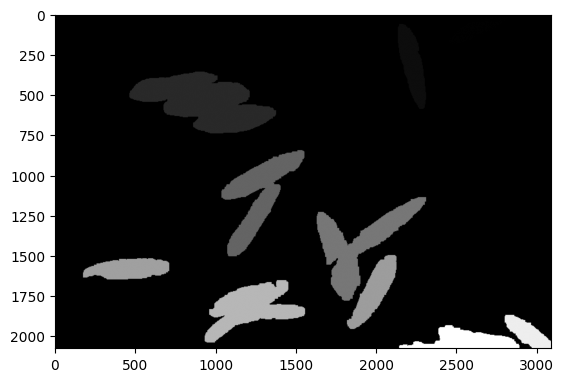

In [ ]:
import numpy as np
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects, remove_small_holes, dilation, footprint_rectangle, erosion
from skimage.util import img_as_ubyte

rec = 25

mask_cleaned = remove_small_holes(segment == 2, area_threshold=5000)
labeled_overlay = label(mask_cleaned)
labeled_overlay = erosion(labeled_overlay, footprint=footprint_rectangle((rec, rec)))
labeled_overlay = remove_small_objects(labeled_overlay, min_size=20000)
labeled_overlay = dilation(labeled_overlay, footprint_rectangle((rec, rec)), mode='ignore')

regions = regionprops(labeled_overlay)
plt.imshow(labeled_overlay, cmap='gray')
labeled_overlay

In [94]:
skimage.io.imsave('Data/mask.png', segment*255)

/home/tibor/tf/tf-gpu/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: Data/mask.png is a low contrast image
  return func(*args, **kwargs)


In [95]:
segment

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2]], dtype=uint8)

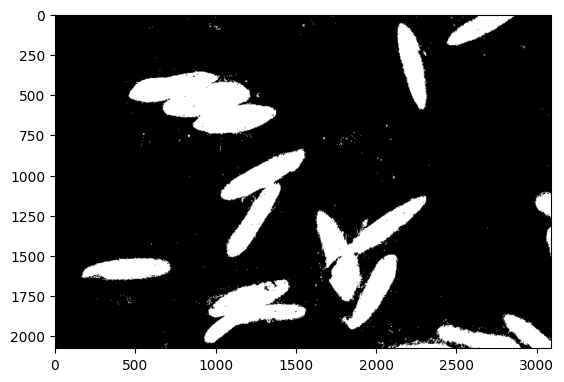

In [93]:
plt.imshow(segment, cmap='gray')

/tmp/ipykernel_675/3363109687.py:2: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  labeled_overlay = remove_small_holes(segment, area_threshold=5000)


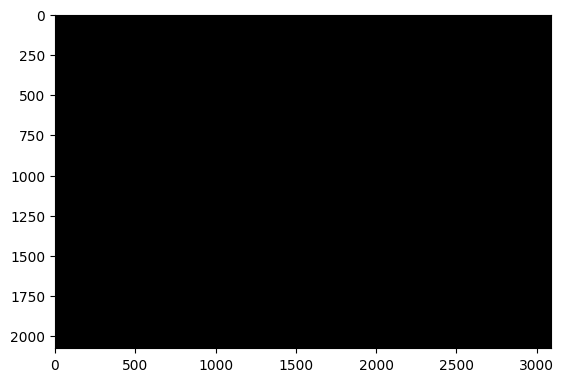

In [68]:
labeled_overlay = label(segment)
labeled_overlay = remove_small_holes(segment, area_threshold=5000)
labeled_overlay
plt.imshow(labeled_overlay, cmap='gray')

In [69]:
segmented_image = []

for i, region in enumerate(regions):
    # Bounding Box extrahieren
    minr, minc, maxr, maxc = region.bbox

    # Ausschnitt des Bildes und der Maske
    cropped_image = image[minr:maxr, minc:maxc]
    mask = labeled_overlay[minr:maxr, minc:maxc] == region.label

    # Maske anwenden (falls nötig, z. B. für transparente Bereiche)
    masked_image = np.zeros_like(cropped_image)
    for c in range(cropped_image.shape[2]):
        masked_image[..., c] = cropped_image[..., c] * mask

    segmented_image.append(masked_image)

Segment 11
Winkel (Orientation): 13.26°
Fläche (Area): 53087.0
Umfang (Perimeter): 1469.18
Rundheit (Roundness): 0.309
Länge (Length): 549.856


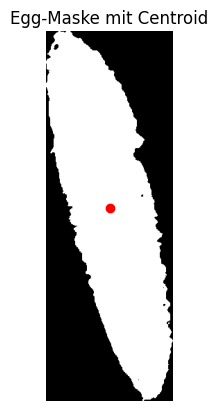

In [94]:
egg = regions[1]
minr, minc, maxr, maxc = egg.bbox
egg_mask = labeled_overlay[minr:maxr, minc:maxc] == egg.label
angle = egg.orientation  # in Radiant
area = egg.area
perimeter = egg.perimeter
roundness = 4 * np.pi * area / (perimeter ** 2) if perimeter != 0 else 0
length = egg.axis_major_length
centroid = egg.centroid


print(f"Segment {i}")
print(f"Winkel (Orientation): {np.degrees(angle):.2f}°")
print(f"Fläche (Area): {area}")
print(f"Umfang (Perimeter): {perimeter:.2f}")
print(f"Rundheit (Roundness): {roundness:.3f}")
print(f"Länge (Length): {length:.3f}")


centroid_local = (centroid[0] - minr, centroid[1] - minc)

plt.imshow(egg_mask, cmap='gray')
plt.plot(centroid_local[1], centroid_local[0], 'ro')  # (x, y) = (col, row)
plt.title("Egg-Maske mit Centroid")
plt.axis('off')
plt.show()

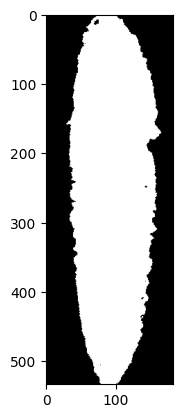

In [93]:
rota_egg = skimage.transform.rotate(egg_mask, -13.26)
plt.imshow(rota_egg, cmap='gray')

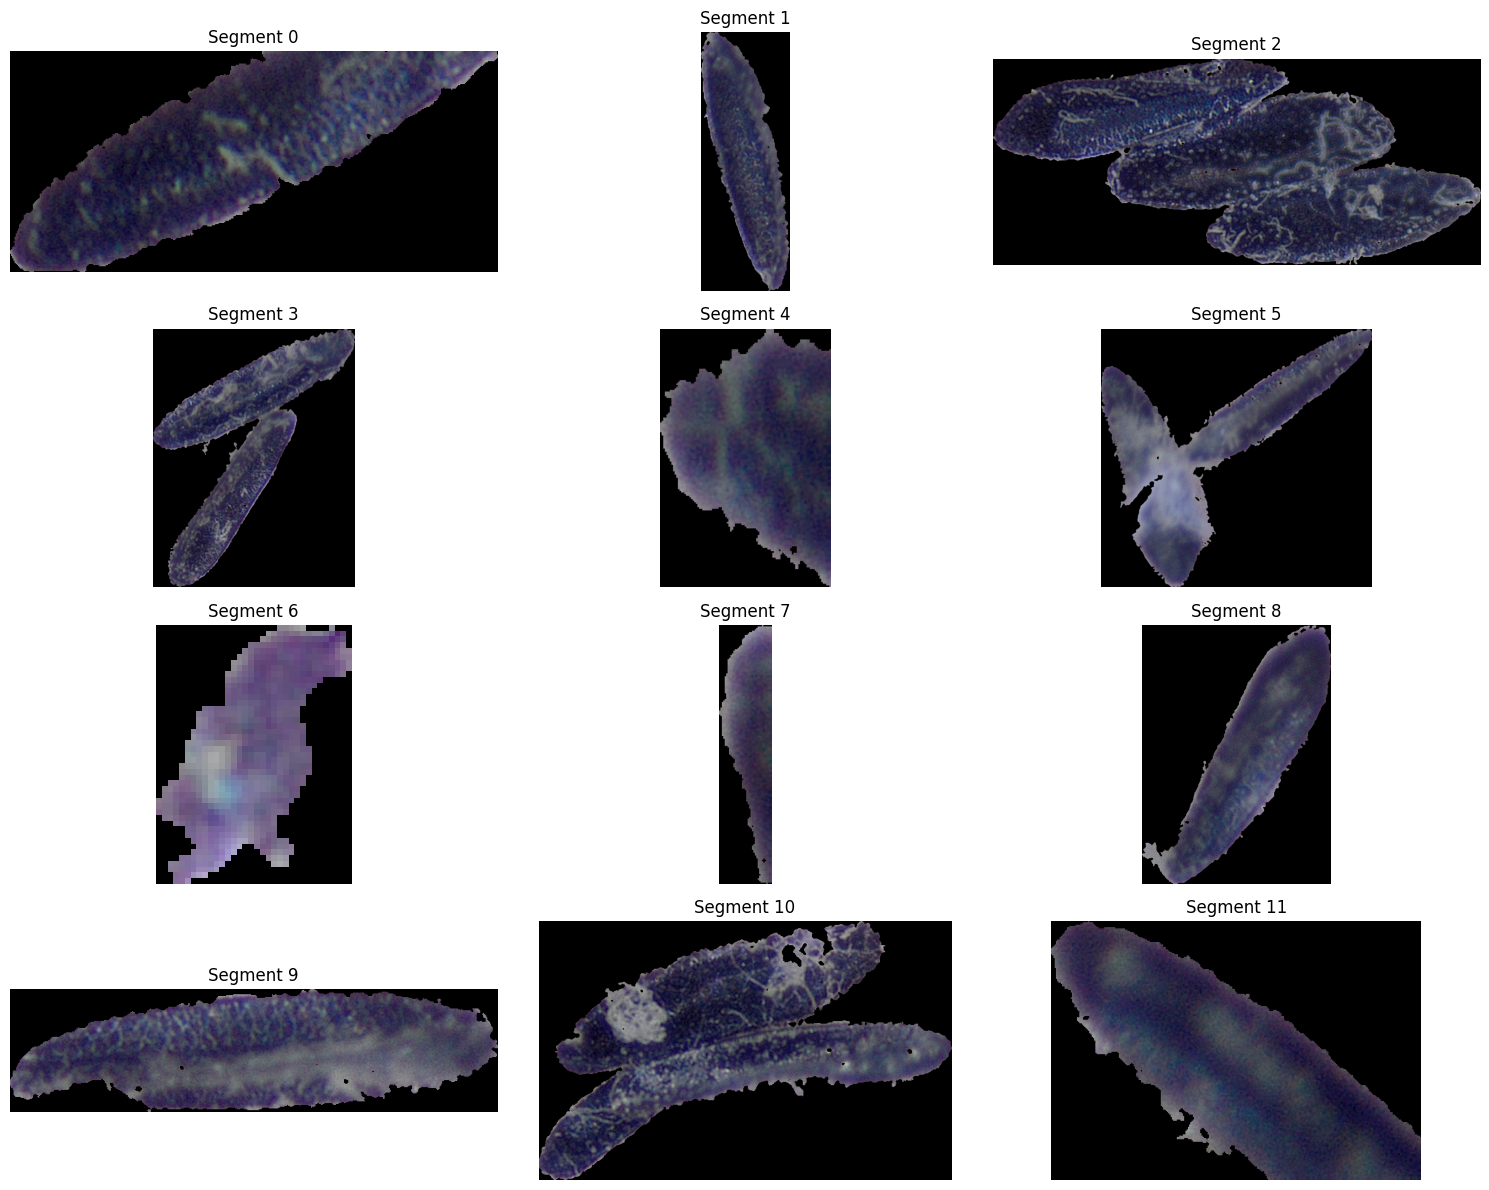

In [88]:
rows = 4  # z. B. 5 Zeilen
cols = 3  # ergibt 25 Plätze, genug für 22 Segmente

fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
axes = axes.flatten()

for i in range(rows * cols):
    ax = axes[i]
    if i < len(segmented_image):
        ax.imshow(segmented_image[i])
        ax.set_title(f"Segment {i}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [62]:
len(segmented_image)

22


Segment 0
Winkel (Orientation): -66.13°
Fläche (Area): 37869.0
Umfang (Perimeter): 1161.67
Rundheit (Roundness): 0.353
Länge (Length): 431.627
Weite (Width): 114.778
Verhältnis: 3.761


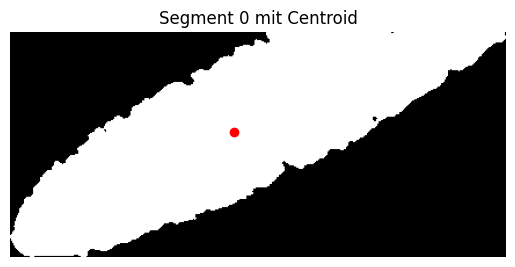


Segment 1
Winkel (Orientation): 13.26°
Fläche (Area): 53087.0
Umfang (Perimeter): 1469.18
Rundheit (Roundness): 0.309
Länge (Length): 549.856
Weite (Width): 124.193
Verhältnis: 4.427


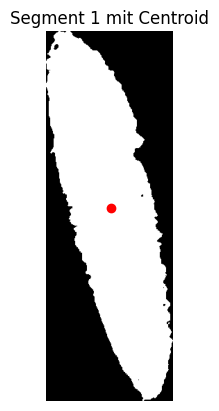


Segment 2
Winkel (Orientation): 76.00°
Fläche (Area): 202843.0
Umfang (Perimeter): 3338.34
Rundheit (Roundness): 0.229
Länge (Length): 854.109
Weite (Width): 323.280
Verhältnis: 2.642


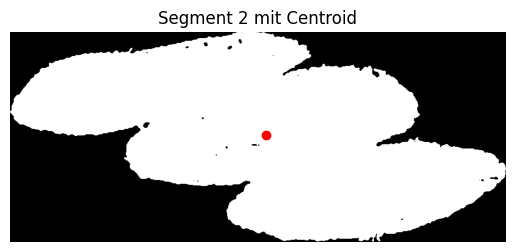


Segment 3
Winkel (Orientation): -29.53°
Fläche (Area): 121342.0
Umfang (Perimeter): 2981.55
Rundheit (Roundness): 0.172
Länge (Length): 767.052
Weite (Width): 319.069
Verhältnis: 2.404


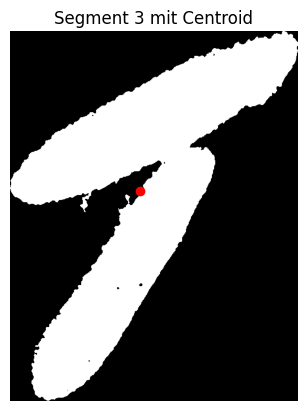


Segment 4
Winkel (Orientation): 15.71°
Fläche (Area): 10920.0
Umfang (Perimeter): 546.20
Rundheit (Roundness): 0.460
Länge (Length): 141.439
Weite (Width): 107.142
Verhältnis: 1.320


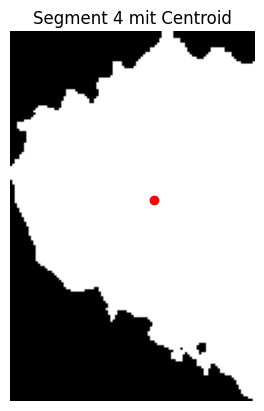


Segment 5
Winkel (Orientation): -50.41°
Fläche (Area): 135537.0
Umfang (Perimeter): 3774.50
Rundheit (Roundness): 0.120
Länge (Length): 818.797
Weite (Width): 436.743
Verhältnis: 1.875


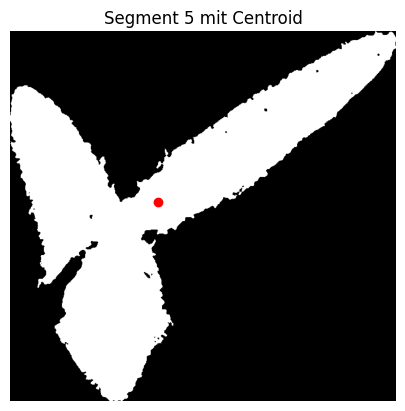


Segment 6
Winkel (Orientation): 3.46°
Fläche (Area): 4179.0
Umfang (Perimeter): 426.31
Rundheit (Roundness): 0.289
Länge (Length): 177.629
Weite (Width): 34.737
Verhältnis: 5.114


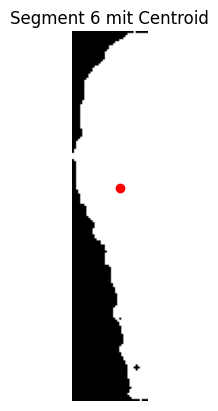


Segment 7
Winkel (Orientation): -30.57°
Fläche (Area): 58164.0
Umfang (Perimeter): 1642.40
Rundheit (Roundness): 0.271
Länge (Length): 548.146
Weite (Width): 141.096
Verhältnis: 3.885


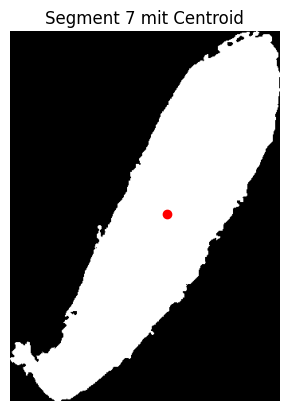


Segment 8
Winkel (Orientation): -86.87°
Fläche (Area): 53749.0
Umfang (Perimeter): 1589.76
Rundheit (Roundness): 0.267
Länge (Length): 548.542
Weite (Width): 127.139
Verhältnis: 4.315


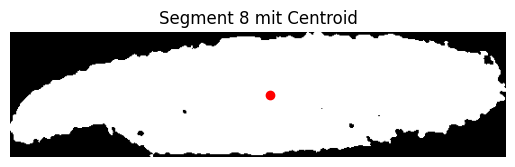


Segment 9
Winkel (Orientation): -73.03°
Fläche (Area): 112511.0
Umfang (Perimeter): 3103.33
Rundheit (Roundness): 0.147
Länge (Length): 636.521
Weite (Width): 289.977
Verhältnis: 2.195


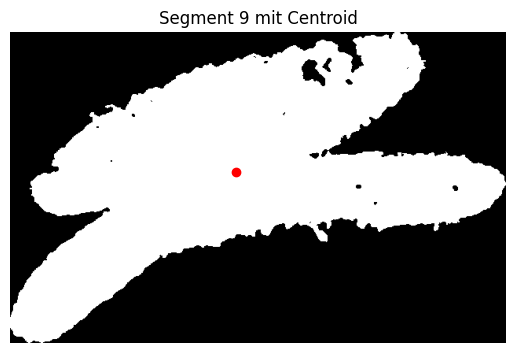


Segment 10
Winkel (Orientation): 55.95°
Fläche (Area): 30803.0
Umfang (Perimeter): 1004.63
Rundheit (Roundness): 0.384
Länge (Length): 345.328
Weite (Width): 116.079
Verhältnis: 2.975


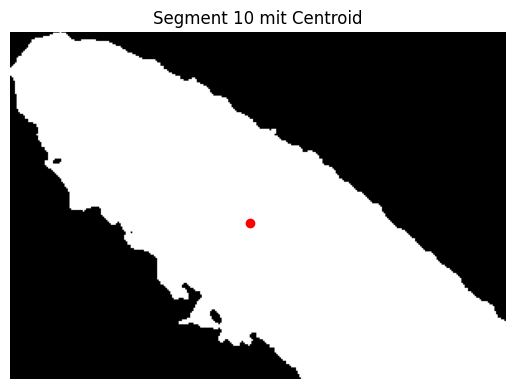


Segment 11
Winkel (Orientation): 88.91°
Fläche (Area): 49636.0
Umfang (Perimeter): 2834.91
Rundheit (Roundness): 0.078
Länge (Length): 684.817
Weite (Width): 139.887
Verhältnis: 4.896


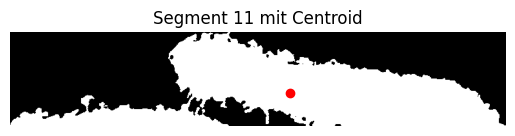

In [97]:
for i, region in enumerate(regions):
    minr, minc, maxr, maxc = region.bbox
    egg_mask = labeled_overlay[minr:maxr, minc:maxc] == region.label
    
    angle = region.orientation
    area = region.area
    perimeter = region.perimeter
    roundness = 4 * np.pi * area / (perimeter ** 2) if perimeter != 0 else 0
    length = region.axis_major_length
    centroid = region.centroid
    centroid_local = (centroid[0] - minr, centroid[1] - minc)
    width = region.axis_minor_length
    Verhältnis = length / width

    print(f"\nSegment {i}")
    print(f"Winkel (Orientation): {np.degrees(angle):.2f}°")
    print(f"Fläche (Area): {area}")
    print(f"Umfang (Perimeter): {perimeter:.2f}")
    print(f"Rundheit (Roundness): {roundness:.3f}")
    print(f"Länge (Length): {length:.3f}")
    print(f"Weite (Width): {width:.3f}")
    print(f"Verhältnis: {Verhältnis:.3f}")

    # Bild anzeigen mit eingezeichnetem Centroid
    plt.imshow(egg_mask, cmap='gray')
    plt.plot(centroid_local[1], centroid_local[0], 'ro')  # (x, y) = (col, row)
    plt.title(f"Segment {i} mit Centroid")
    plt.axis('off')
    plt.show()

In [103]:
import pandas as pd
import random
import matplotlib.pyplot as plt

# Beispielhafte Filterkriterien
roundness_min, roundness_max = 0.2, 0.3
ratio_min, ratio_max = 3.5, 5.0

# Filtere den DataFrame
filtered_df = df[
    (df['roundness'] >= roundness_min) & (df['roundness'] <= roundness_max) &
    (df['length_width_ratio'] >= ratio_min) & (df['length_width_ratio'] <= ratio_max)
]

# Optional: mische die Reihenfolge
filtered_df = filtered_df.sample(frac=1).reset_index(drop=True)

NameError: name 'df' is not defined

In [ ]:
for i in range(min(n, len(filtered_df))):
    img_path = filtered_df.iloc[i]['Data/segmented_mask']  # oder wie auch immer der Bildpfad heißt
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"Roundness: {filtered_df.iloc[i]['roundness']:.2f}, Ratio: {filtered_df.iloc[i]['length_width_ratio']:.2f}")
    plt.axis('off')
    plt.show()